Здесь будет показан мой вариант построения модели для предсказание цен домов. Весь датасет взят с соревнования на kaggle.com. 

**Импортируем необходимые библиотеки**

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, data importing
import matplotlib.pyplot as plt 
import seaborn as sns
import lightgbm as lgb
import xgboost as xgb
import warnings
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import norm, skew
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
warnings.filterwarnings("ignore")

Импортируем тестовый и тренировочный датасеты

In [2]:
test = pd.read_csv("test.csv")
train = pd.read_csv("train.csv")

Проверяем размер тренировочного датасета

In [3]:
train.shape

(1460, 81)

Смотрим общую статистику по тренировочному датасету

In [4]:
train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [5]:
train.nunique()

Id               1460
MSSubClass         15
MSZoning            5
LotFrontage       110
LotArea          1073
                 ... 
MoSold             12
YrSold              5
SaleType            9
SaleCondition       6
SalePrice         663
Length: 81, dtype: int64

Построим scatter plot (точечная диаграмма) для обнаружения выбросов

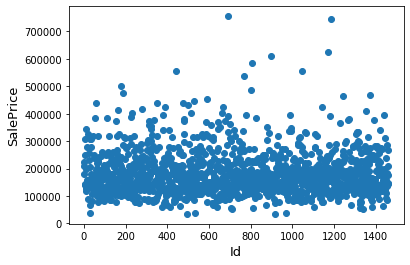

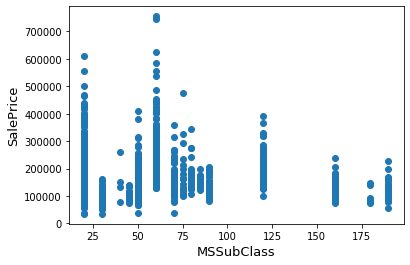

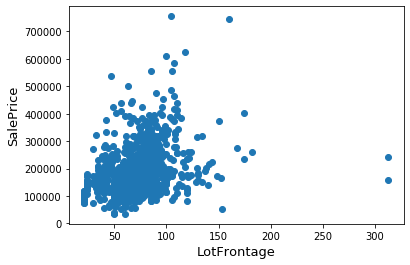

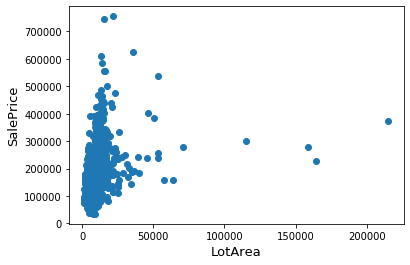

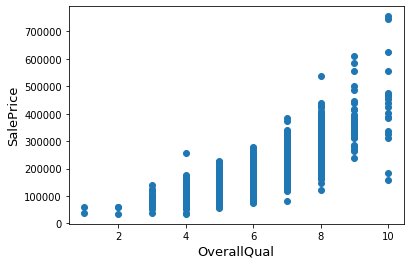

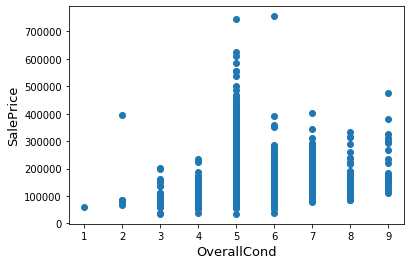

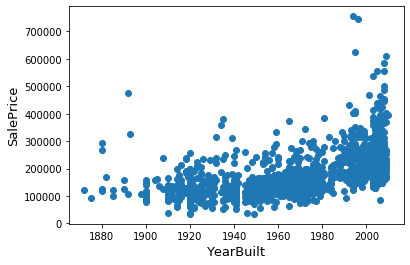

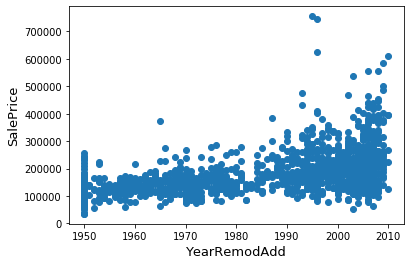

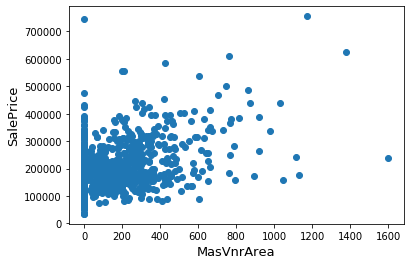

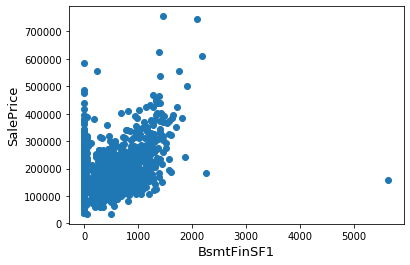

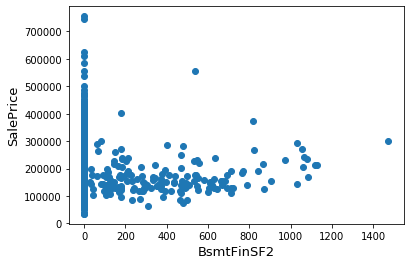

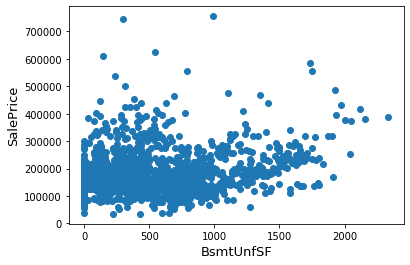

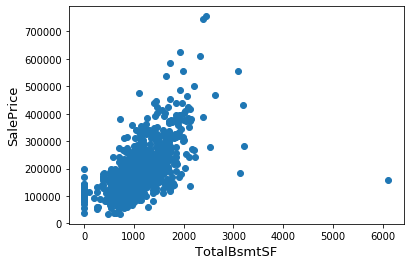

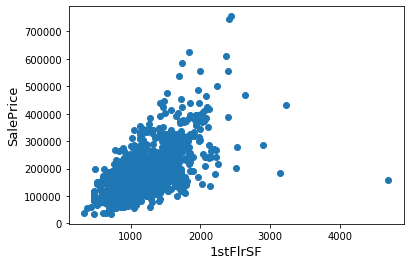

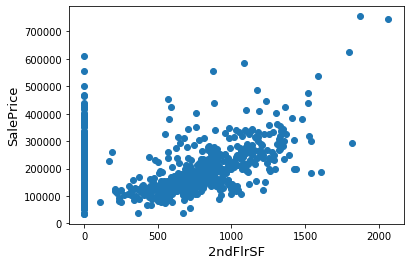

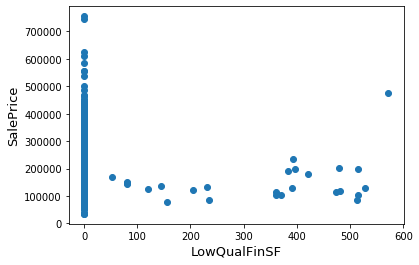

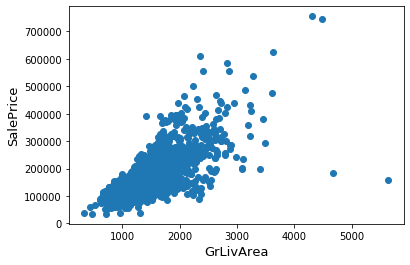

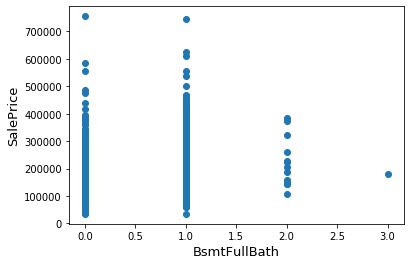

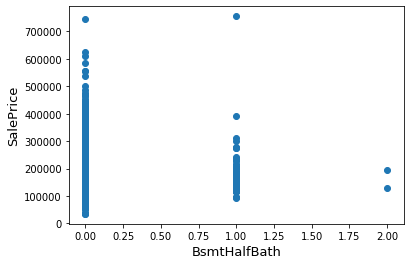

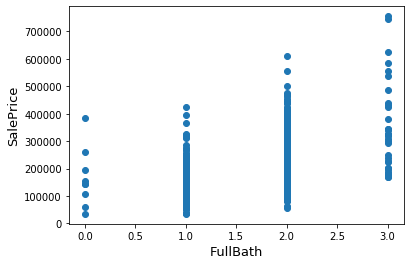

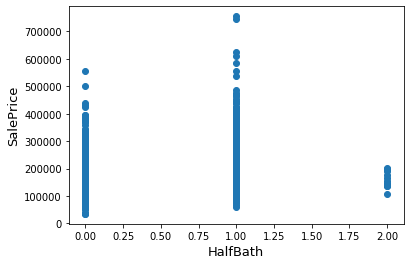

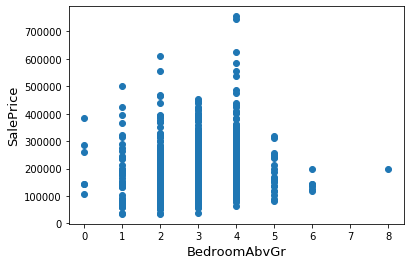

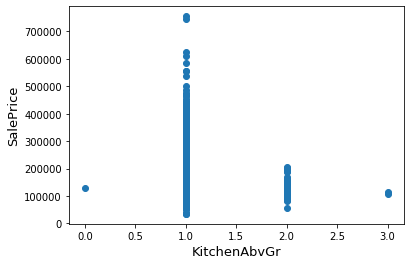

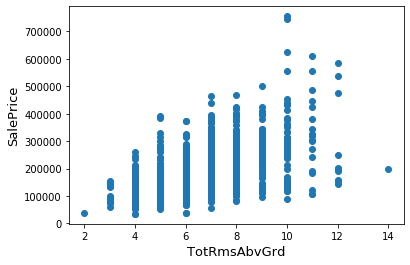

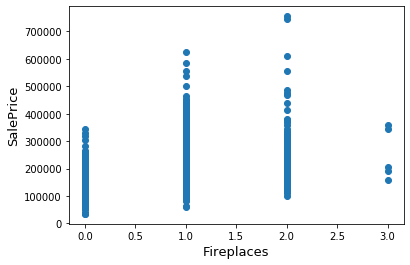

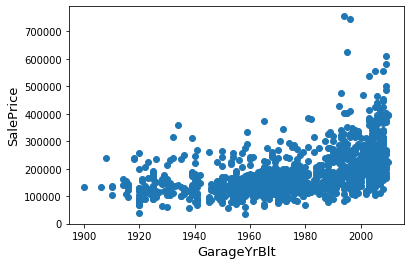

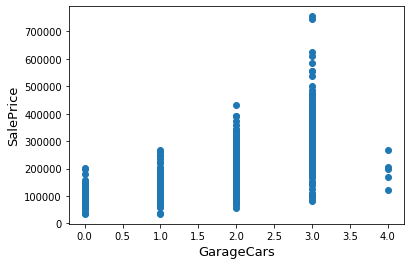

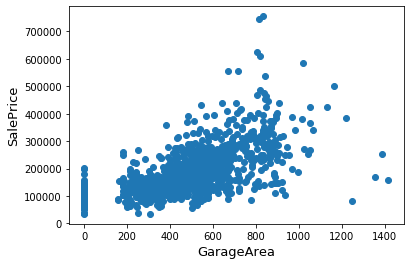

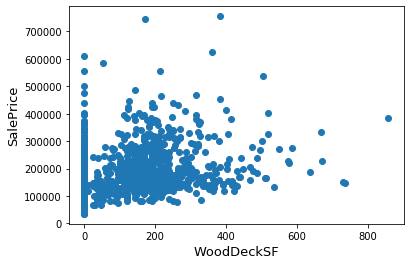

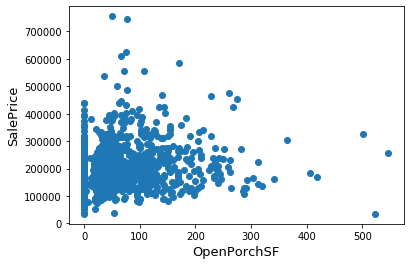

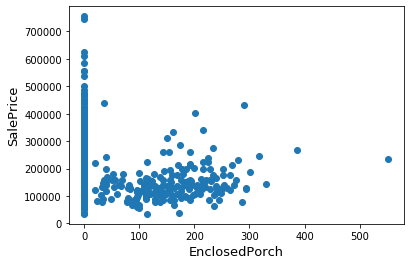

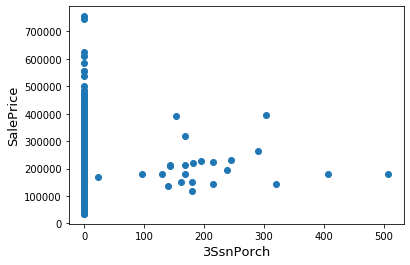

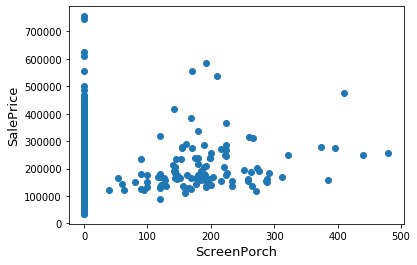

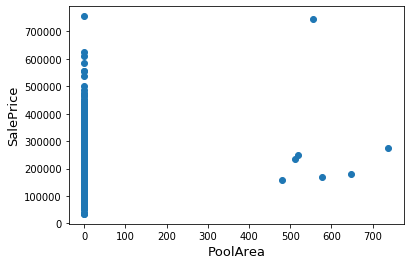

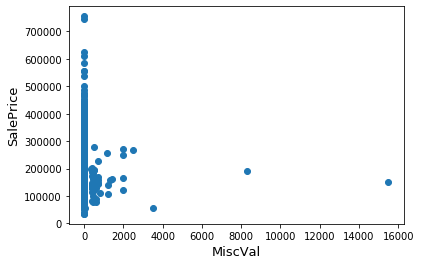

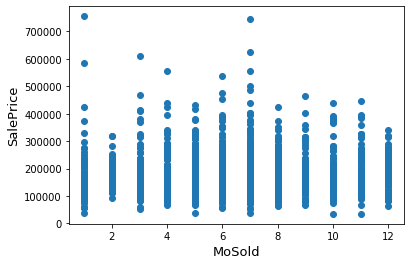

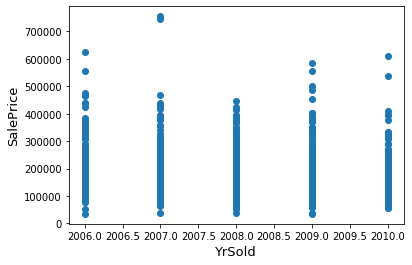

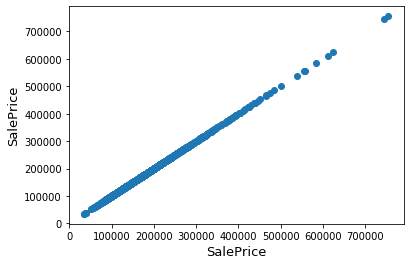

In [6]:
num_col=train._get_numeric_data().columns.tolist()
for col in num_col:
    fig, axs = plt.subplots()
    plt.scatter(x = train[col], y = train['SalePrice'])
    plt.ylabel('SalePrice', fontsize=13)
    plt.xlabel(f'{col}', fontsize=13)
    plt.show()

На основе анализа точечной диаграммы удаляем экстримальные точки

In [7]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
train = train.drop(train[(train['LotFrontage']>200)].index)
train = train.drop(train[(train['LotFrontage']>200)].index)
train = train.drop(train[(train['LotFrontage']>100000)].index)
train = train.drop(train[(train['LotFrontage']>100000)].index)
train = train.drop(train[(train['BsmtFinSF1']>5000)].index)
train = train.drop(train[(train['TotalBsmtSF']>5000)].index)
train = train.drop(train[(train['1stFlrSF']>4000)].index)
train = train.drop(train[(train['GrLivArea']>5000)].index)
train = train.drop(train[(train['GrLivArea']>5000)].index)

Сохраняем столбец с ценой отдельно

In [8]:
Sale_Price=train.iloc[:,80]
Sale_Price.shape

(1457,)

Удаляем столбец с ценой, далее будем объединять тестовый и тренировочный датасеты

In [9]:
train=train.drop(["SalePrice"],axis=1)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [10]:
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [11]:
test.shape

(1459, 80)

In [12]:
data= pd.concat([train,test], keys=['x', 'y'])
data.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
x 0   1          60       RL         65.0     8450   Pave   NaN      Reg   
  1   2          20       RL         80.0     9600   Pave   NaN      Reg   
  2   3          60       RL         68.0    11250   Pave   NaN      IR1   
  3   4          70       RL         60.0     9550   Pave   NaN      IR1   
  4   5          60       RL         84.0    14260   Pave   NaN      IR1   

    LandContour Utilities  ... ScreenPorch PoolArea PoolQC Fence MiscFeature  \
x 0         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
  1         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
  2         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
  3         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   
  4         Lvl    AllPub  ...           0        0    NaN   NaN         NaN   

    MiscVal MoSold  YrSold  SaleType  SaleCondition  
x 0       0      2    2008        WD         Normal  
  1       0      5    2007        WD         Normal  
  2       0      9    2008        WD         Normal  
  3       0      2    2006        WD        Abnorml  
  4       0     12    2008        WD         Normal  

[5 rows x 80 columns]

Проверяем размерность итогового датасета

In [13]:
data.shape

(2916, 80)

**Подготовка данных и работа с признаками(EDA)**

Ищем пропущенные значения, строим график для наглядности и удаляем столбцы, в которых более 85 % пропущенных значений.

Получаем список пропущенных значений по общему количеству

In [14]:
data.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          2907
MiscFeature     2811
Alley           2718
Fence           2345
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageQual       159
GarageYrBlt      159
GarageFinish     159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
BsmtHalfBath       2
dtype: int64

В процентном выражении:

In [15]:
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691358
MiscFeature,96.399177
Alley,93.209877
Fence,80.418381
FireplaceQu,48.696845
LotFrontage,16.666667
GarageFinish,5.452675
GarageYrBlt,5.452675
GarageQual,5.452675
GarageCond,5.452675


Text(0.5, 1.0, 'Percent missing data by feature')

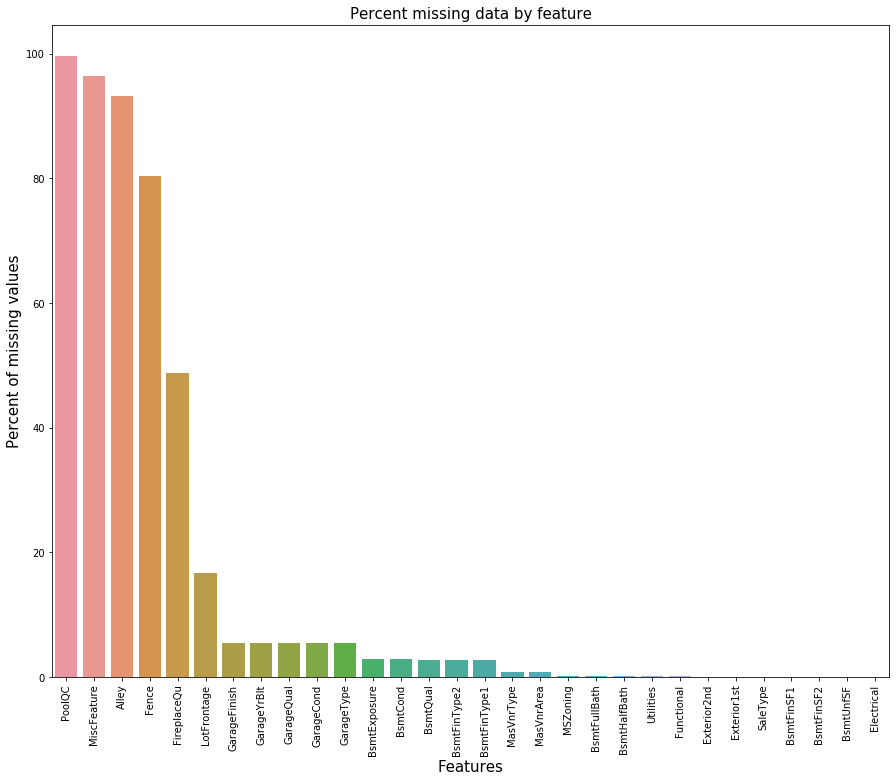

In [16]:
ay, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation='90')
sns.barplot(x=data_na.index, y=data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [17]:
data=data.drop(["Id","MiscFeature","PoolQC", "Alley"],axis=1)

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2916 entries, (x, 0) to (y, 1458)
Data columns (total 76 columns):
MSSubClass       2916 non-null int64
MSZoning         2912 non-null object
LotFrontage      2430 non-null float64
LotArea          2916 non-null int64
Street           2916 non-null object
LotShape         2916 non-null object
LandContour      2916 non-null object
Utilities        2914 non-null object
LotConfig        2916 non-null object
LandSlope        2916 non-null object
Neighborhood     2916 non-null object
Condition1       2916 non-null object
Condition2       2916 non-null object
BldgType         2916 non-null object
HouseStyle       2916 non-null object
OverallQual      2916 non-null int64
OverallCond      2916 non-null int64
YearBuilt        2916 non-null int64
YearRemodAdd     2916 non-null int64
RoofStyle        2916 non-null object
RoofMatl         2916 non-null object
Exterior1st      2915 non-null object
Exterior2nd      2915 non-null object
MasVnrType    

Находим столбцы с числовыми значениями. Отсутвующие значения заменяем средними.

In [19]:
num_col=data._get_numeric_data().columns.tolist()
num_col

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [20]:
for col in num_col:
    data[col].fillna(data[col].mean(),inplace=True)

Находим столбцы с категориальными признаками. Отсутвующие значения заменяем модой (наиболее часто встречающееся значение).

In [21]:
cat_col=set(data.columns)-set(num_col)
cat_col

{'BldgType',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtQual',
 'CentralAir',
 'Condition1',
 'Condition2',
 'Electrical',
 'ExterCond',
 'ExterQual',
 'Exterior1st',
 'Exterior2nd',
 'Fence',
 'FireplaceQu',
 'Foundation',
 'Functional',
 'GarageCond',
 'GarageFinish',
 'GarageQual',
 'GarageType',
 'Heating',
 'HeatingQC',
 'HouseStyle',
 'KitchenQual',
 'LandContour',
 'LandSlope',
 'LotConfig',
 'LotShape',
 'MSZoning',
 'MasVnrType',
 'Neighborhood',
 'PavedDrive',
 'RoofMatl',
 'RoofStyle',
 'SaleCondition',
 'SaleType',
 'Street',
 'Utilities'}

In [22]:
for col in cat_col:
    data[col].fillna(data[col].mode()[0],inplace=True)

Посчитаем общее количество каждого значения в категориальном признаке. Можно поэкспериментировать с удалением признаков в которох максимально доминирует одно значение, но пока все оставим все как есть

In [23]:
for i in cat_col:
    print(data[i].value_counts())

Gable      2310
Hip         549
Gambrel      22
Flat         19
Mansard      11
Shed          5
Name: RoofStyle, dtype: int64
TA    1364
Gd    1208
Ex     256
Fa      88
Name: BsmtQual, dtype: int64
Y    2720
N     196
Name: CentralAir, dtype: int64
1Fam      2422
TwnhsE     227
Duplex     109
Twnhs       96
2fmCon      62
Name: BldgType, dtype: int64
PConc     1306
CBlock    1234
BrkTil     311
Slab        49
Stone       11
Wood         5
Name: Foundation, dtype: int64
Lvl    2622
HLS     119
Bnk     115
Low      60
Name: LandContour, dtype: int64
CompShg    2875
Tar&Grv      22
WdShake       9
WdShngl       7
Roll          1
Membran       1
Metal         1
Name: RoofMatl, dtype: int64
TA    2760
Fa     124
Gd      24
Po       5
Ex       3
Name: GarageQual, dtype: int64
Attchd     1878
Detchd      779
BuiltIn     185
Basment      36
2Types       23
CarPort      15
Name: GarageType, dtype: int64
SBrkr    2669
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dty

Проверяем корреляцию признаков, строим heatmap. 

In [24]:
corr_dataset = train.copy()
corr_dataset['SalePrice'] = Sale_Price

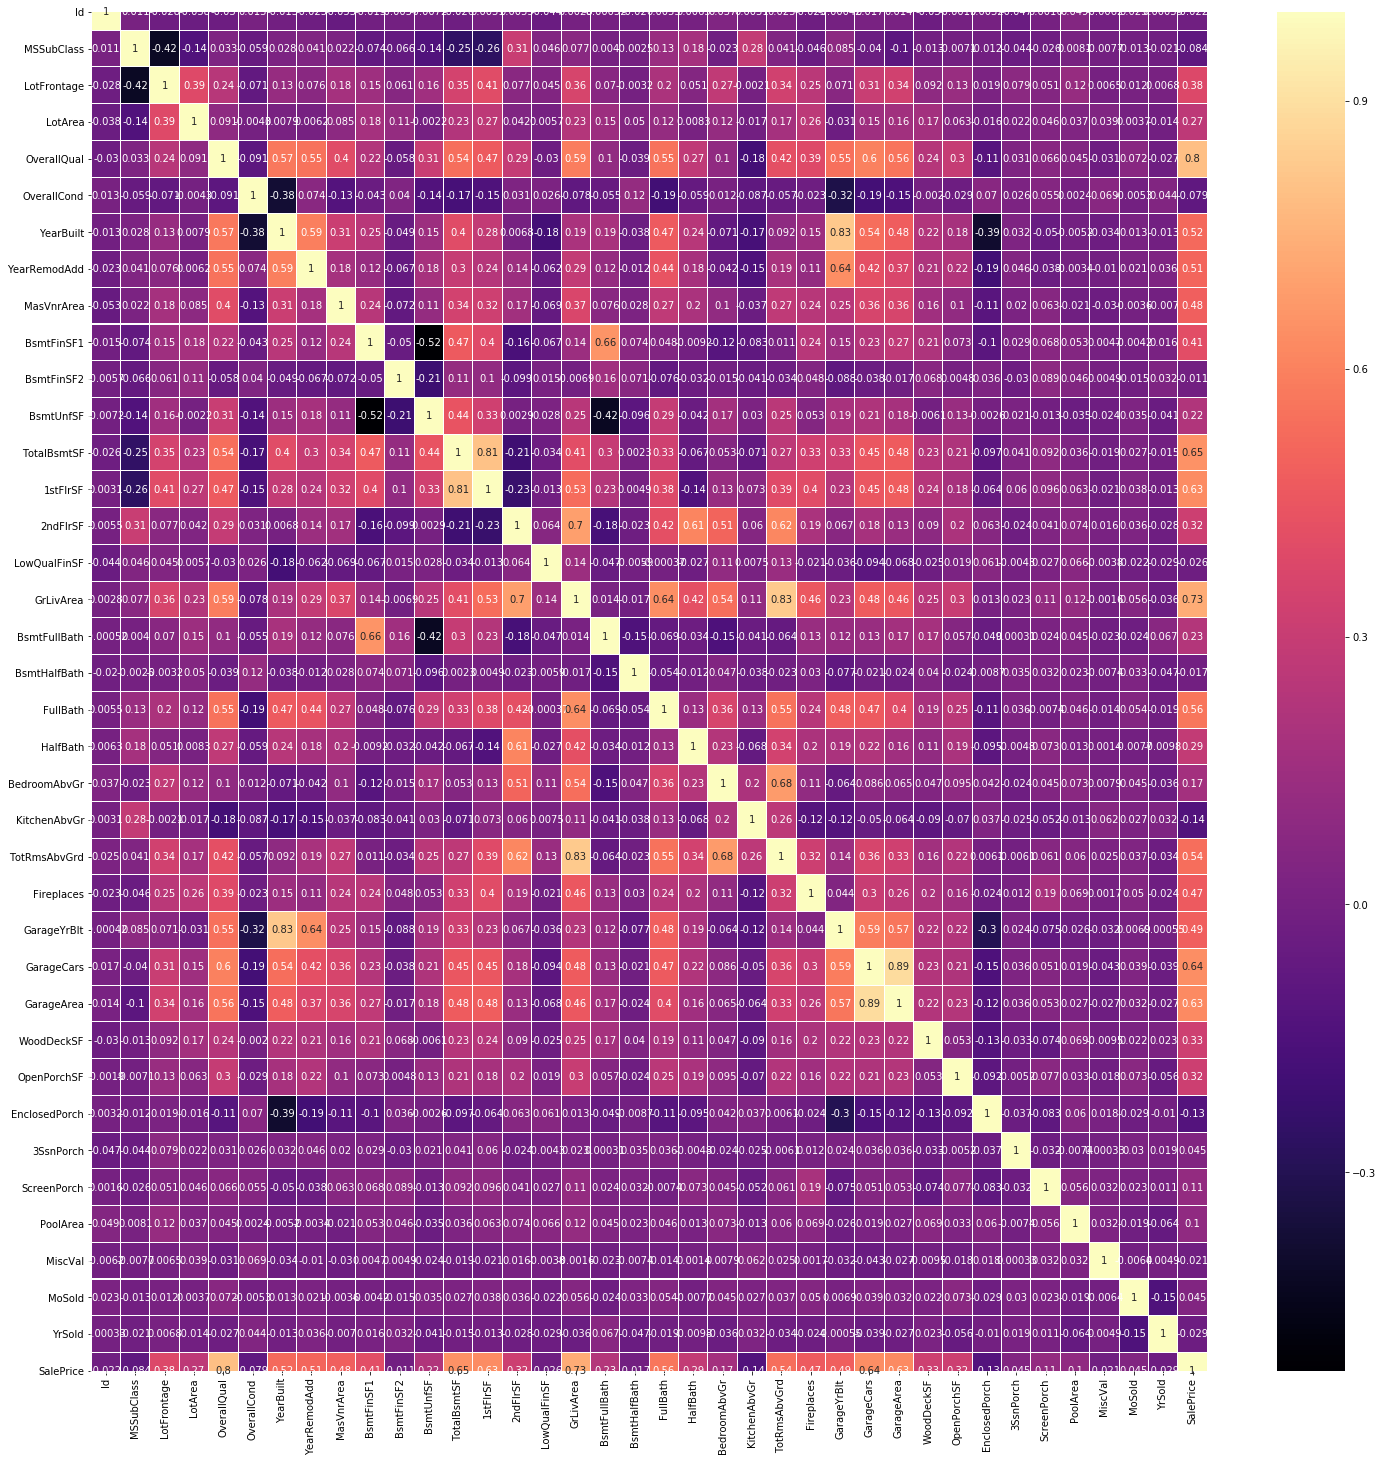

In [25]:
plt.figure(figsize=(25, 25))
sns.heatmap(corr_dataset.corr(), annot=True, linewidths=0.05,cmap="magma")
plt.show()

Признаки, которые более всего коррелируют с ценой в виде списка

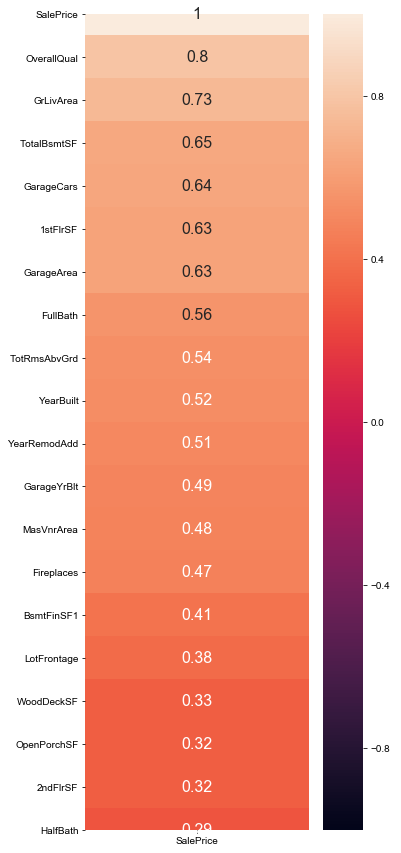

In [26]:
corr = corr_dataset.corr()
plt.figure(figsize=(5,15))
sns.heatmap(corr[['SalePrice']].sort_values(by=['SalePrice'],ascending=False).head(20),annot_kws={"size": 16},vmin=-1, annot=True)
sns.set(font_scale=2)

In [27]:
data.shape

(2916, 76)

Далее посмотрим распределение зависимой величины и сравним его с нормальным, постоим график распределий и график QQ plot.


 mu = 180891.01 and sigma = 79478.94



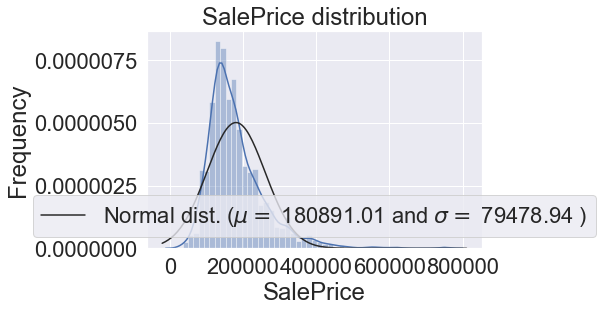

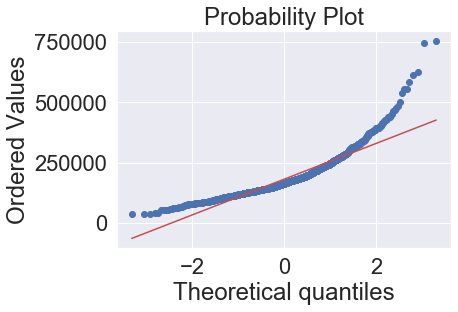

In [28]:
from scipy import stats
from scipy.stats import norm

sns.distplot(Sale_Price, fit=norm);

# Getting normal distribution
(mu, sigma) = norm.fit(Sale_Price)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='lower center')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#QQ-plot
fig = plt.figure()
res = stats.probplot(Sale_Price, plot=plt)
plt.show()

На графике видно, что зависимая величина имеет правостороннее смещение (положительная асимметрия). Приведем распределение к нормальному виду с помощью логарифмического преобразования.



 mu = 12.02 and sigma = 0.40



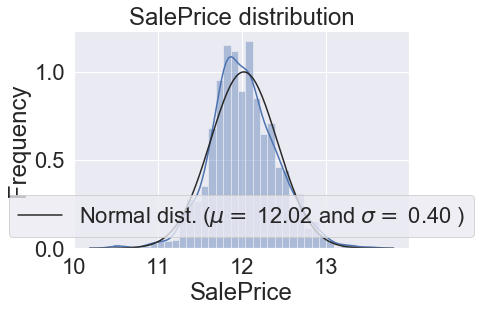

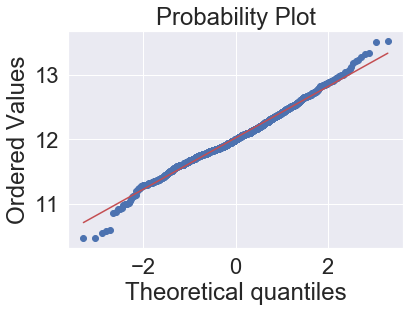

In [29]:
#We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
Sale_Price = np.log1p(Sale_Price)

#Check the new distribution 
sns.distplot(Sale_Price , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(Sale_Price)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='lower center')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(Sale_Price, plot=plt)
plt.show()

Проверим теперь смещение распределения других признаков

In [30]:
from scipy.stats import skew

numeric_feats = data.dtypes[data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nСмещение в числовых признаках: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(20)


Смещение в числовых признаках: 



,Skew
MiscVal,21.935910
PoolArea,17.685603
LotArea,13.139681
LowQualFinSF,12.082427
3SsnPorch,11.370087
KitchenAbvGr,4.299698
BsmtFinSF2,4.143573
EnclosedPorch,4.001570
ScreenPorch,3.944305
BsmtHalfBath,3.928946



 mu = 1498.06 and sigma = 496.80



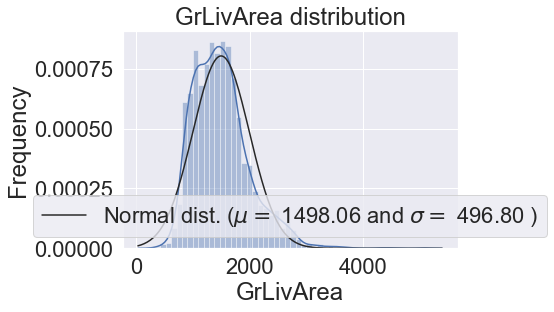

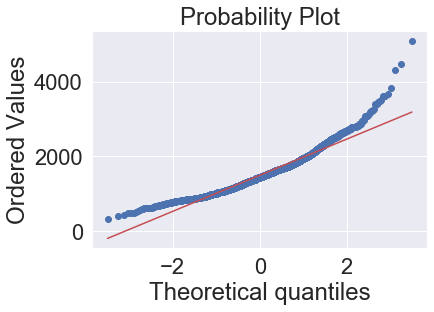

In [31]:
from scipy import stats
from scipy.stats import norm

sns.distplot(data.GrLivArea, fit=norm);

# Getting normal distribution
(mu, sigma) = norm.fit(data.GrLivArea)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='lower center')
plt.ylabel('Frequency')
plt.title('GrLivArea distribution')

#QQ-plot
fig = plt.figure()
res = stats.probplot(data.GrLivArea, plot=plt)
plt.show()

Также будем использовать логарфмическое преобразование. Также попробуем преобразование Бокса-Кокса.

In [32]:
skewness = skewness[abs(skewness) > 0.75]
print("Всего {} числовых признаков изменены преобразованием Бокса-Кокса".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    
    data[feat] = boxcox1p(data[feat], lam)
    
#Data_copy[skewed_features] = np.log1p(Data_copy[skewed_features])

Всего 36 числовых признаков изменены преобразованием Бокса-Кокса



 mu = 13.17 and sigma = 0.96



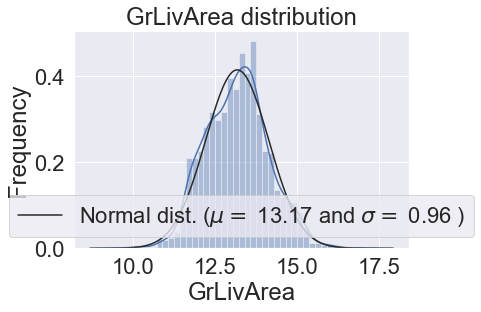

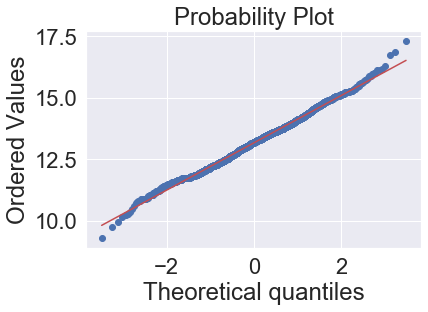

In [33]:
sns.distplot(data.GrLivArea, fit=norm);
# Getting normal distribution
(mu, sigma) = norm.fit(data.GrLivArea)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


# Plot the distribution
plt.ylabel('Frequency')
plt.title('GrLivArea distribution')
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='lower center')

#QQ-plot
fig = plt.figure()
res = stats.probplot(data.GrLivArea, plot=plt)
plt.show()

 Готовим окончательный датасет для моделирования. Для категориальных признаков делаем "one hot" преобразование. В итоге получаем 275 признаков

In [34]:
X=pd.get_dummies(data)
X.shape

(2916, 278)

Разделяем данные обратно на тренировочную и тестовую выборки

In [35]:
Train_data=X.loc["x"]
Train_data.shape

(1457, 278)

In [36]:
Test_data=X.loc["y"]
Test_data.shape

(1459, 278)

Возвращаем цену в тренировочный датасет

In [37]:
Train_data.insert(2,column="SalePrice",value=Sale_Price)
Train_data.head()

,MSSubClass,LotFrontage,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,5.684507,5.831328,12.247699,19.212182,2.440268,2.055642,14.187527,14.187527,8.059126,11.170327,...,0,0,0,1,0,0,0,0,1,0
1,3.858807,6.221214,12.109016,19.712205,2.259674,2.602594,14.145138,14.145138,0.000000,12.062832,...,0,0,0,1,0,0,0,0,1,0
2,5.684507,5.914940,12.317171,20.347241,2.440268,2.055642,14.184404,14.185966,7.646538,10.200343,...,0,0,0,1,0,0,0,0,1,0
3,5.968981,5.684507,11.849405,19.691553,2.440268,2.055642,14.047529,14.135652,0.000000,8.274266,...,0,0,0,1,1,0,0,0,0,0
4,5.684507,6.314735,12.429220,21.325160,2.602594,2.055642,14.182841,14.182841,9.391827,10.971129,...,0,0,0,1,0,0,0,0,1,0


In [38]:
Train_data

,MSSubClass,LotFrontage,SalePrice,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,5.684507,5.831328,12.247699,19.212182,2.440268,2.055642,14.187527,14.187527,8.059126,11.170327,...,0,0,0,1,0,0,0,0,1,0
1,3.858807,6.221214,12.109016,19.712205,2.259674,2.602594,14.145138,14.145138,0.000000,12.062832,...,0,0,0,1,0,0,0,0,1,0
2,5.684507,5.914940,12.317171,20.347241,2.440268,2.055642,14.184404,14.185966,7.646538,10.200343,...,0,0,0,1,0,0,0,0,1,0
3,5.968981,5.684507,11.849405,19.691553,2.440268,2.055642,14.047529,14.135652,0.000000,8.274266,...,0,0,0,1,1,0,0,0,0,0
4,5.684507,6.314735,12.429220,21.325160,2.602594,2.055642,14.182841,14.182841,9.391827,10.971129,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,5.684507,5.744420,12.072547,18.960528,2.259674,2.055642,14.181278,14.182841,0.000000,0.000000,...,0,0,0,1,0,0,0,0,1,0
1456,3.858807,6.337529,12.254868,20.994868,2.259674,2.259674,14.148295,14.164038,7.003881,11.473247,...,0,0,0,1,0,0,0,0,1,0
1457,5.968981,5.859551,12.493133,19.476345,2.440268,2.750250,14.089451,14.192207,0.000000,8.823108,...,0,0,0,1,0,0,0,0,1,0
1458,3.858807,5.914940,11.864469,19.760176,2.055642,2.259674,14.103852,14.176584,0.000000,5.321541,...,0,0,0,1,0,0,0,0,1,0


In [39]:
Test_data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,3.858807,6.221214,20.479373,2.055642,2.259674,14.121376,14.121376,0.000000,10.105326,7.397498,...,0,0,0,1,0,0,0,0,1,0
1,3.858807,6.244956,21.327220,2.259674,2.259674,14.116605,14.116605,6.808145,11.901094,0.000000,...,0,0,0,1,0,0,0,0,1,0
2,5.684507,6.073289,21.196905,2.055642,2.055642,14.178149,14.179714,0.000000,11.476685,0.000000,...,0,0,0,1,0,0,0,0,1,0
3,5.684507,6.172972,19.865444,2.259674,2.259674,14.179714,14.179714,3.858807,10.749651,0.000000,...,0,0,0,1,0,0,0,0,1,0
4,7.020909,5.093857,17.257255,2.602594,2.055642,14.170316,14.170316,0.000000,8.720170,0.000000,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,7.620056,3.932510,14.081426,1.820334,2.440268,14.135652,14.135652,0.000000,0.000000,0.000000,...,0,0,0,1,0,0,0,0,1,0
1455,7.620056,3.932510,14.013314,1.820334,2.055642,14.135652,14.135652,0.000000,8.622254,0.000000,...,0,0,0,1,1,0,0,0,0,0
1456,3.858807,7.620056,22.782058,2.055642,2.440268,14.119786,14.176584,0.000000,12.703313,0.000000,...,0,0,0,1,1,0,0,0,0,0
1457,6.337529,5.744420,20.046557,2.055642,2.055642,14.170316,14.170316,0.000000,9.301176,0.000000,...,0,0,0,1,0,0,0,0,1,0


Разделяем данные на независимые переменные X и зависимую Y

In [40]:
x=Train_data.drop(["SalePrice"],axis=True)
y=Train_data["SalePrice"]


In [41]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.25,random_state=40)

В качестве моделей будем использовать линейные: ElasticNetCV, LassoCV, RidgeCV; Ансамбли: GradientBoostingRegressor, XGBosst и LGB. Гиперпараметры подбирались через RandomizedSearchCV и GridSearchCV.

In [42]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

alphas=[1e-9,1e-8,1e-7,1e-6]

ridgecv_reg= make_pipeline(RidgeCV(alphas=alphas, cv=kfolds))
ridgecv_reg.fit(x_train, y_train)
y_hat=ridgecv_reg.predict(x_test)
print('RidgeCV')
print('R2: ',r2_score(y_test,y_hat))
print('MAE: ',mean_absolute_error(y_test,y_hat))
print('MSE: ',mean_squared_error(y_test,y_hat))

RidgeCV
R2:  0.8977707969453262
MAE:  0.08405179418091935
MSE:  0.014974681618330333


In [43]:
lgb_regressor=lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.035, n_estimators=2177, max_bin=50, bagging_fraction=0.65,bagging_freq=5, bagging_seed=7, 
                                feature_fraction=0.201, feature_fraction_seed=7,n_jobs=-1)
lgb_regressor.fit(x_train, y_train)
y_hat=lgb_regressor.predict(x_test)
print('LGBM')
print('R2: ',r2_score(y_test,y_hat))
print('MAE: ',mean_absolute_error(y_test,y_hat))
print('MSE: ',mean_squared_error(y_test,y_hat))

LGBM
R2:  0.9034805797142457
MAE:  0.08103204359793346
MSE:  0.014138304374651066


In [44]:
XGBR = xgb.XGBRegressor(max_depth=4, n_estimators=2000, min_samples_leaf=15, min_samples_split=14)
XGBR.fit(x_train, y_train)
y_hat=XGBR.predict(x_test)
print('LGBM')
print('R2: ',r2_score(y_test,y_hat))
print('MAE: ',mean_absolute_error(y_test,y_hat))
print('MSE: ',mean_squared_error(y_test,y_hat))

[17:48:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
LGBM
R2:  0.8953679795029438
MAE:  0.0799953763484449
MSE:  0.01532664979485427


In [45]:
gb_reg = GradientBoostingRegressor(n_estimators=2000, learning_rate=0.03005, max_depth=4, max_features='sqrt', min_samples_leaf=15, min_samples_split=14, loss='huber', random_state =42)
gb_reg.fit(x_train, y_train)
y_hat=gb_reg.predict(x_test)
print('GradientBoostingRegressor')
print('R2: ',r2_score(y_test,y_hat))
print('MAE: ',mean_absolute_error(y_test,y_hat))
print('MSE: ',mean_squared_error(y_test,y_hat))

GradientBoostingRegressor
R2:  0.910108378764889
MAE:  0.07543259295593682
MSE:  0.013167454777392864


In [46]:
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006]
l1ratio=[0.87, 0.9,0.92, 0.95,0.97, 0.99, 1]

elasticv_reg= make_pipeline(ElasticNetCV(alphas=alphas, cv=kfolds, l1_ratio=l1ratio))
elasticv_reg.fit(x_train, y_train)
y_hat=elasticv_reg.predict(x_test)
print('ElasticNetCV')
print('R2: ',r2_score(y_test,y_hat))
print('MAE: ',mean_absolute_error(y_test,y_hat))
print('MSE: ',mean_squared_error(y_test,y_hat))

ElasticNetCV
R2:  0.9029020931803945
MAE:  0.0849319108079163
MSE:  0.01422304191936498


In [47]:
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

lassocv_reg= make_pipeline(LassoCV(alphas=alphas, cv=kfolds))
lassocv_reg.fit(x_train, y_train)
y_hat=lassocv_reg.predict(x_test)
print('LassoCV')
print('R2: ',r2_score(y_test,y_hat))
print('MAE: ',mean_absolute_error(y_test,y_hat))
print('MSE: ',mean_squared_error(y_test,y_hat))

LassoCV
R2:  0.9034295827157003
MAE:  0.08456450600334565
MSE:  0.014145774488805232


In [48]:
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

alphas=[1e-9,1e-8,1e-7,1e-6]

ridgecv_reg= make_pipeline(RidgeCV(alphas=alphas, cv=kfolds))
ridgecv_reg.fit(x_train, y_train)
y_hat=ridgecv_reg.predict(x_test)
print('RidgeCV')
print('R2: ',r2_score(y_test,y_hat))
print('MAE: ',mean_absolute_error(y_test,y_hat))
print('MSE: ',mean_squared_error(y_test,y_hat))

RidgeCV
R2:  0.8977707969453262
MAE:  0.08405179418091935
MSE:  0.014974681618330333


Сделаем стакинг моделей с финальным регрессором ExtraTreesRegressor

In [49]:
estimators = [('lgbm', lgb_regressor),
              ('gbr', gb_reg),   
              ('lasso', lassocv_reg),   
              ('ridge', ridgecv_reg),   
              ('elasticnet', elasticv_reg)]

stack_reg=StackingRegressor(estimators=estimators,final_estimator=ExtraTreesRegressor(n_estimators=50),n_jobs=-1)
stack_reg.fit(x_train, y_train)
y_hat=stack_reg.predict(x_test)
print('StackingRegressor')
print('R2: ',r2_score(y_test,y_hat))
print('MAE: ',mean_absolute_error(y_test,y_hat))
print('MSE: ',mean_squared_error(y_test,y_hat))

StackingRegressor
R2:  0.9039160854201302
MAE:  0.08322782056968832
MSE:  0.014074510868551831


Сделаем финальное предсказание, коэффициенты подбирались экспериментальным путем

In [50]:
final_pred = np.floor(np.expm1(stack_reg.predict(Test_data)))*0.16 + np.floor(np.expm1(lgb_regressor.predict(Test_data)))*0.67 + np.floor(np.expm1(ridgecv_reg.predict(Test_data)))*0.17

In [51]:
sub=pd.read_csv('submission.csv')

In [52]:
sub['SalePrice']=final_pred

In [53]:
sub.to_csv('submission.csv',index=False)